In [1]:
# Needed to import modules from helpers
import sys
import os

current_dir = os.getcwd()
# Gehe einen Ordner nach oben
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import torch
import esm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from helpers import helper
import time

# kleineres Modell 'esm2_t6_8M_UR50D' zum testen 
# verwendet 36-layer Transformer trained on UniParc" (ca. 670 Mio. Parameter ) im Paper.
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()

if torch.cuda.is_available():
    model = model.cuda()
    print("Modell auf GPU geladen.")

### Hypothesis 1:

The model learns to group proteins based on their evolutionary origin/relationship (homology). Proteins belonging to the same sequence family (orthologs = genes with same ancestor, which have diverged in their sequence a bit) are expected to lie close to one another in the embedding space, even if their sequences have diverged due to mutations.

While the organization of proteins in the representation space is diffuse prior to training, we expect clear clusters to emerge after training, reflecting evolutionary relationships.

### Method:

Each protein (sequence x) is processed by the Transformer model. We extract the final hidden representation for sequence token. To obtain a single vector representation for the entire protein, we average these values across the sequence length (mean pooling).​	
 
This process projects each Sequence/Protein as a single point in a high-dimensional space. To visualize this high-dimensional structure, we use t-SNE (t-Distributed Stochastic Neighbor Embedding) to project the embeddings onto two dimensions for analysis

In [3]:
"""
TODO: Replace the code here which fetches from uniprot with one that fetches from eggNOG
eggNOG 5.0: A hierarchical, functionally and phylogenetically
annotated orthology resource based on 5090 organisms and 2502 viruses. Nucleic
Acids Res. 47, D309–D314 (2019)
"""
"""
genes = [
    #"HBA", "HBB", "MB", "NGB",   # Die Globin-Familie
    "TP53",                      # Outgroup (Krebsforschung)
    "GAPDH",                     # Stoffwechsel (Enzym)
    "ACTB",                      # Zytoskelett (extrem konserviert!)
    "INS"                        # Signalhormon (Insulin)
]

# Lateinische Namen
organisms = {
    "Homo sapiens",
    "Pan troglodytes",
    "Gorilla gorilla",
    "Mus musculus",
    "Rattus norvegicus",
    "Canis lupus familiaris",
    "Felis catus",
    "Bos taurus",
    "Sus scrofa",
    "Ovis aries"
    #"Gallus gallus", # Chicken
    #"Anolis carolinensis",
    #"Chelonia mydas",      # Meeresschildkröte
    #"Xenopus tropicalis",
    #"Salmo salar",         # Lachs
    #"Danio rerio"
}

sequences_dict = {}

for gene in genes:
    for org in organisms:
        
        # this will give us orthologous genes (genes in different species that evolved from a common ancestral gene)
        seq = helper.fetch_uniprot_sequence(gene, org)
        
        if seq:
            # build key 
            key = f"{gene}_{org}"
            sequences_dict[key] = seq
            
        # Kurz warten um die API nicht zu überlasten
        time.sleep(0.2)

print("\nDictionary created!")
print(f"Amount of sequences: {len(sequences_dict)}")
"""

'\ngenes = [\n    #"HBA", "HBB", "MB", "NGB",   # Die Globin-Familie\n    "TP53",                      # Outgroup (Krebsforschung)\n    "GAPDH",                     # Stoffwechsel (Enzym)\n    "ACTB",                      # Zytoskelett (extrem konserviert!)\n    "INS"                        # Signalhormon (Insulin)\n]\n\n# Lateinische Namen\norganisms = {\n    "Homo sapiens",\n    "Pan troglodytes",\n    "Gorilla gorilla",\n    "Mus musculus",\n    "Rattus norvegicus",\n    "Canis lupus familiaris",\n    "Felis catus",\n    "Bos taurus",\n    "Sus scrofa",\n    "Ovis aries"\n    #"Gallus gallus", # Chicken\n    #"Anolis carolinensis",\n    #"Chelonia mydas",      # Meeresschildkröte\n    #"Xenopus tropicalis",\n    #"Salmo salar",         # Lachs\n    #"Danio rerio"\n}\n\nsequences_dict = {}\n\nfor gene in genes:\n    for org in organisms:\n\n        # this will give us orthologous genes (genes in different species that evolved from a common ancestral gene)\n        seq = helper.fetch_

In [4]:
import requests
import pandas as pd
from io import StringIO
from Bio import SeqIO # pip install biopython

# 1. Choose arbitrary eggNOG Group IDs (These act as your "Labels")
# COG0008: Glutamyl-tRNA synthetase (Translation)
# COG0012: Ribosome-binding factor A (Ribosomal)
# COG0016: Phenylalanyl-tRNA synthetase alpha subunit (Translation)
# COG0080: Ribosomal protein L11 (Structural)
# COG0092: Ribosomal protein S3 (Structural)

target_groups = ["COG0008", "COG0012", "COG0016", "COG0080", "COG0092"]

data = []

print("Fetching group data...")

for group_id in target_groups:
    # 2. Fetch all sequences for this specific group directly
    url = f"http://eggnogapi5.embl.de/nog_data/json/fasta/{group_id}"
    
    try:
        response = requests.get(url)
        if response.status_code == 200:
            fasta_content = response.json().get('fasta', '')
            
            # 3. Parse the FASTA data
            # We limit to 50 sequences per group just to keep it fast/readable
            count = 0
            for record in SeqIO.parse(StringIO(fasta_content), "fasta"):
                if count >= 50: break 

                print(record)
                data.append({
                    "Sequence": str(record.seq),
                    "Label": group_id  # This is the color for your plot
                })
                count += 1
            print(f"  -> Fetched {count} sequences for {group_id}")
            
    except Exception as e:
        print(f"Error fetching {group_id}: {e}")

# 4. Result
df = pd.DataFrame(data)
print("\n--- Final Dataset for Figure 2A ---")
print(df.head())
print(f"Total rows: {len(df)}")

Fetching group data...
ID: 287.DR97_2066
Name: 287.DR97_2066
Description: 287.DR97_2066
Number of features: 0
Seq('MTSSYVGRFAPTPSGYLHFGSLVAAVASYLDARAVGGRWLVRMEDLDPPREVPG...ERL')
ID: 287.DR97_4795
Name: 287.DR97_4795
Description: 287.DR97_4795
Number of features: 0
Seq('MTTVRTRIAPSPTGDPHVGTAYIALFNLCFARQHGGQFILRIEDTDQLRSTRES...IPG')
ID: 287.DR97_92
Name: 287.DR97_92
Description: 287.DR97_92
Number of features: 0
Seq('MSKPETTAAPNFLRQIVQADLDAGKHAKIVTRFPPEPNGYLHIGHAKSICLNFG...GQG')
ID: 292.DM42_2743
Name: 292.DM42_2743
Description: 292.DM42_2743
Number of features: 0
Seq('MNPGYRGRFAPSPTGPLHFGSLVGALASWLDARAHGGTWLVRIEDLDGPRTVPG...RAG')
ID: 292.DM42_295
Name: 292.DM42_295
Description: 292.DM42_295
Number of features: 0
Seq('MSTERNDAPAASNFIRNIIDDDNRTGKWGGRVETRFPPEPNGYLHIGHAKSICL...KPA')
ID: 292.DM42_3036
Name: 292.DM42_3036
Description: 292.DM42_3036
Number of features: 0
Seq('MTRPVRTRFAPSPTGFIHLGNIRSALYPWAFARKMKGTFVLRIEDTDVERSSQE...ALA')
ID: 301.JNHE01000009_gene3258
Name: 301.JNHE01000009_gen

In [5]:
# Get the labels for genes and species and the according sequences
labels = list(df["Label"])
seqs = list(df["Sequence"])

In [6]:
# --- 1. Define Function for Unigram Embeddings ---
# This baseline maps each sequence to a vector of normalized amino acid counts 
def get_unigram_embeddings(sequences):
    alphabet = "ACDEFGHIKLMNPQRSTVWY"
    aa_to_idx = {aa: i for i, aa in enumerate(alphabet)}
    
    # Create matrix: (Num_Sequences x 20)
    embeddings = np.zeros((len(sequences), 20))
    
    for i, seq in enumerate(sequences):
        if len(seq) == 0: continue
        
        # Count residues
        for char in seq.upper():
            if char in aa_to_idx:
                idx = aa_to_idx[char]
                embeddings[i, idx] += 1
                
        # Normalize by length to get frequencies
        embeddings[i] = embeddings[i] / len(seq)
        
    return embeddings

# --- 2. Calculate and Project ---
print("Calculating Unigram Embeddings...")
emb_unigram = get_unigram_embeddings(seqs)

Calculating Unigram Embeddings...


In [7]:
# 2. Get embeddings before pretraining (natürlich ist hier ein Problem, 
# dass wir den seed nicht kennen alleine deshalb werden sich hier Sachen vom original Paper unterscheiden)
print("Berechne UNTRAINIERTE Embeddings...")
untrained_model = helper.randomize_model(model)
if torch.cuda.is_available(): 
    untrained_model = untrained_model.cuda()

# Schritt 1: Hidden Representations residues holen (mit untrainiertem Modell)
token_reps_untrained, batch_strs_untrained = helper.get_hidden_representations(untrained_model, alphabet, labels, seqs)
# Schritt 2: Mean Pooling der residues durchführen
emb_untrained = helper.get_protein_embedding(token_reps_untrained, batch_strs_untrained)

Berechne UNTRAINIERTE Embeddings...
Processing 250 sequences in batches of 10...


In [8]:
# 1. Get embeddings after pretraining
print("Berechne TRAINIERTE Embeddings...")
# Schritt 1: Hidden Representations residues holen
token_reps_trained, batch_strs_trained = helper.get_hidden_representations(model, alphabet, labels, seqs)
# Schritt 2: Mean Pooling der residuesdurchführen
emb_trained = helper.get_protein_embedding(token_reps_trained, batch_strs_trained)

Berechne TRAINIERTE Embeddings...
Processing 250 sequences in batches of 10...


In [9]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=5, random_state=42, init='pca', learning_rate='auto')
emb_2d_untrained = tsne.fit_transform(emb_untrained)

tsne_trained = TSNE(n_components=2, perplexity=5, random_state=42, init='pca', learning_rate='auto')
emb_2d_trained = tsne_trained.fit_transform(emb_trained)

tsne = TSNE(n_components=2, perplexity=5, random_state=42, init='pca', learning_rate='auto')
emb_2d_unigram = tsne.fit_transform(emb_unigram)

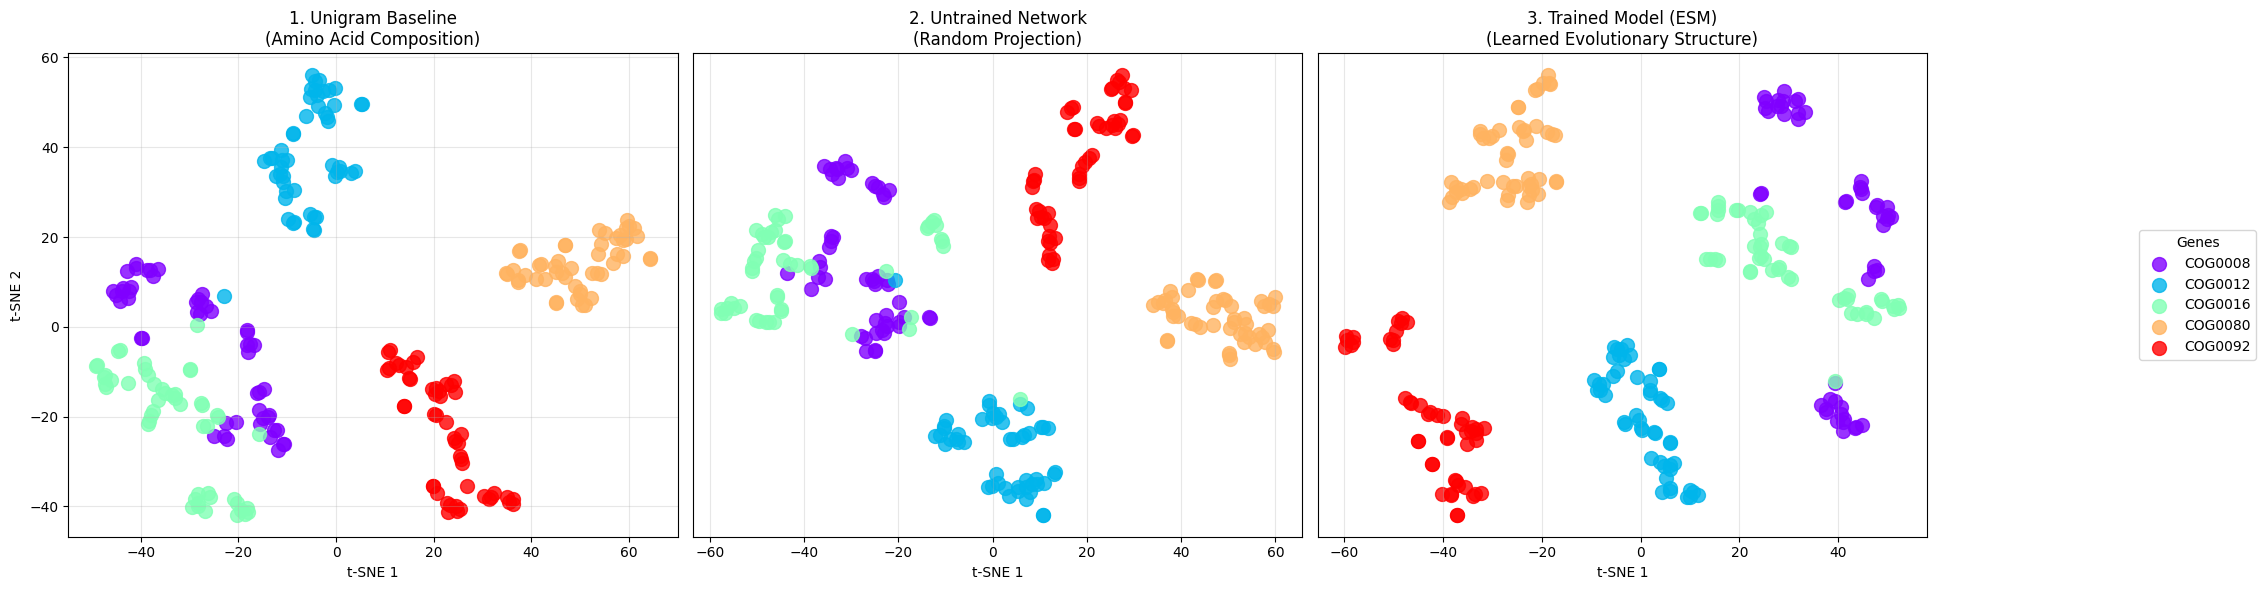

In [10]:
# 1. Setup Colors
# Extract unique gene names for coloring
unique_genes = sorted(list(set([l.split('_')[0] for l in labels])))
colors = cm.rainbow(np.linspace(0, 1, len(unique_genes)))
gene_color_map = dict(zip(unique_genes, colors))

# 2. Setup Figure (Now 1 row, 3 columns)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))

# 3. Plotting Loop (Iterate by Gene to keep colors/legend clean)
for gene in unique_genes:
    # Find all indices for this specific gene
    # (Assuming labels list is available as defined in previous steps)
    indices = [i for i, label in enumerate(labels) if label.startswith(gene)]
    
    color = gene_color_map[gene]
    
    if indices:
        # --- Panel 1: Unigram Baseline (Input from your snippet) ---
        ax1.scatter(emb_2d_unigram[indices, 0], emb_2d_unigram[indices, 1], 
                    color=color, s=100, alpha=0.8, label=gene)
        
        # --- Panel 2: Untrained Model ---
        ax2.scatter(emb_2d_untrained[indices, 0], emb_2d_untrained[indices, 1], 
                    color=color, s=100, alpha=0.8) # No label here to avoid duplicate legend
        
        # --- Panel 3: Trained Model ---
        ax3.scatter(emb_2d_trained[indices, 0], emb_2d_trained[indices, 1], 
                    color=color, s=100, alpha=0.8)

# 4. Styling and Titles

# Ax1: Unigram
ax1.set_title("1. Unigram Baseline\n(Amino Acid Composition)")
ax1.set_xlabel("t-SNE 1")
ax1.set_ylabel("t-SNE 2")
ax1.grid(True, alpha=0.3)

# Ax2: Untrained
ax2.set_title("2. Untrained Network\n(Random Projection)")
ax2.set_xlabel("t-SNE 1")
ax2.set_yticks([]) # Optional: Hide ticks for cleaner look
ax2.grid(True, alpha=0.3)

# Ax3: Trained
ax3.set_title("3. Trained Model (ESM)\n(Learned Evolutionary Structure)")
ax3.set_xlabel("t-SNE 1")
ax3.set_yticks([]) 
ax3.grid(True, alpha=0.3)

# 5. Legend
# We only need one legend since the colors are consistent
# Placing it outside the last plot
handles, plot_labels = ax1.get_legend_handles_labels()
fig.legend(handles, plot_labels, loc='center right', title="Genes", bbox_to_anchor=(1.08, 0.5))

plt.tight_layout()
# Adjust right margin to make room for the external legend
plt.subplots_adjust(right=0.92) 
plt.show()

Hypothesis 2: unsupervised learning encodes biological variations into the structure of the representation space. Das Modell lernt also ohne explizite Labels, fundamentale biologische Unterscheidungen zwischen species und gen familie

Die Autoren wenden eine Hauptkomponentenanalyse (PCA) auf die gelernten Repräsentationen von vier orthologen Genen über vier verschiedene Spezies hinweg an

Beobachtung: Die PCA enthüllt, dass das trainierte Modell automatisch Achsen bildet, die biologisch interpretierbar sind:
- Eine Spezies-Achse (horizontal), die Organismen unterscheidet.
- Eine Orthologie-Achse (vertikal), die Gene unterscheidet.

Vergleich: Diese Struktur fehlt in untrainierten Modellen oder simplen Unigram-Modellen komplett.

In [11]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import numpy as np

# Ensure emb_unigram exists (calculated in the previous step)
if 'emb_unigram' not in locals():
    print("Warning: emb_unigram not found. Please run the Unigram calculation cell first.")

# --- 1. SETUP COLORS AND LABELS ---

# Generate consistent colors for Genes (The "Orthology Axis")
unique_genes = sorted(list(set([l.split('_')[0] for l in labels])))
colors = cm.viridis(np.linspace(0, 1, len(unique_genes)))
gene_color_map = dict(zip(unique_genes, colors))

# Generate short labels for Species (The "Species Axis")
unique_species = sorted(list(set([l.split('_')[1] for l in labels])))
species_code_map = {
    "Homo sapiens": "Hu",
    "Pan troglodytes": "Ch",
    "Gorilla gorilla": "Go",
    "Mus musculus": "Mu",
    "Rattus norvegicus": "Ra",
    "Canis lupus familiaris": "Do",
    "Felis catus": "Ca",
    "Bos taurus": "Co",
    "Sus scrofa": "Pi",
    "Ovis aries": "Sh"
}

# --- 2. DEFINE PLOTTING FUNCTION ---

def plot_pca_custom(ax, embeddings, title, label_list):
    # 1. Compute PCA
    pca = PCA(n_components=2)
    emb_pca = pca.fit_transform(embeddings)
    var = pca.explained_variance_ratio_
    
    # 2. Plot points
    for i, full_label in enumerate(label_list):
        parts = full_label.split('_')
        gene_name = parts[0]
        species_name = parts[1]
        
        # Get style
        c = gene_color_map.get(gene_name, 'gray')
        # Fallback to first 2 chars if species not in map
        txt = species_code_map.get(species_name, species_name[:2]) 
        
        # Scatter point
        ax.scatter(emb_pca[i, 0], emb_pca[i, 1], color=c, s=80, alpha=0.7)
        
        # Add text label (Species Axis)
        ax.text(emb_pca[i, 0]+0.02, emb_pca[i, 1]+0.02, txt, fontsize=9, fontweight='bold')

    # 3. Styling
    ax.set_title(title)
    ax.set_xlabel(f"PC1 ({var[0]:.1%} Var)")
    ax.set_ylabel(f"PC2 ({var[1]:.1%} Var)")
    ax.grid(True, linestyle='--', alpha=0.4)

# --- 3. EXECUTE PLOTTING (1 Row, 3 Columns) ---

# Increased width to (24, 7) to fit 3 panels comfortably
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 7))

# PANEL 1: Unigram Baseline
# Paper claim: "PCA recovers... axes... in the trained representation space but not in the untrained or unigram spaces." 
plot_pca_custom(ax1, emb_unigram, "1. UNIGRAM: Composition Only\n(No Distinct Axes)", labels)

# PANEL 2: Untrained (Control)
plot_pca_custom(ax2, emb_untrained, "2. UNTRAINED: Random Weights\n(No Structure)", labels)

# PANEL 3: Trained (ESM)
plot_pca_custom(ax3, emb_trained, "3. TRAINED: Orthology vs Species\n(Recovered Biological Axes)", labels)

# --- 4. LEGEND ---
legend_elements = [Line2D([0], [0], marker='o', color='w', label=gene,
                          markerfacecolor=color, markersize=10) 
                   for gene, color in gene_color_map.items()]

fig.legend(handles=legend_elements, loc='upper center', ncol=len(unique_genes), 
           title="Orthology Axis (Gene Identity)")

plt.tight_layout()
plt.subplots_adjust(top=0.85) # Adjust for legend space
plt.show()

IndexError: list index out of range

# !! SHOULD ORGANIZE IN A GRID 

Hypothesis 3: biological properties are encoded along independent directions in the representation space

Then if we have two related sequences which only distiguish themselves by one unique property, they should only be differing along one of these separate axes

Analogy: 

o	Vector arithmetics in NLP: King – Royalty = Queen 

Vector arithmetics in Biology: Hemoglobin - Rat = .. 

-	In SI Appendix, Fig. S1, we find that learning improves recovery of target proteins under queries encoded as linear transformations along the species or gene axes
o	•  "Queries encoded as linear transformations...": Das ist die "Rechen-Anfrage". Die Forscher haben genau das getan, was wir besprochen haben:
o	Beispiel (species axis): Sie haben den Vektor-Unterschied zwischen zwei Spezies berechnet, z.B. .
o	Dann haben sie eine "query" (Anfrage) gestellt: 
o	•  "Target proteins": Das ist die korrekte Antwort auf die Rechen-Anfrage. In unserem Beispiel wäre das "target protein" das Maus-Hämoglobin.
o	•  "Recovery of target proteins": Das bedeutet "das korrekte Ziel-Protein finden".
o	Das Modell macht die Rechnung () und erhält einen Ergebnis-Vektor.
o	Dann schaut es im gesamten Datensatz nach: Welches "echte" Protein-Embedding liegt diesem Ergebnis-Vektor am nächsten?
o	Wenn es "Maus-Hämoglobin" findet, war die "recovery" erfolgreich.
o	•  "Learning improves recovery...": Das ist das Ergebnis.
o	Bei einem untrainierten Modell (vor dem "learning") ist das Ergebnis dieser Rechnung Müll. Es findet das "target protein" nicht.
o	Bei einem trainierten Modell (nach dem "learning") funktioniert die Rechnung. Das Modell "recovers" (findet) das korrekte "target protein" (Maus-Hämoglobin) mit hoher Genauigkeit.

Vector(Human Insulin)−Vector(Human)+Vector(Mouse)≈Vector(Mouse Insulin)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# --- 1. PREPARATION: Calculate "Mean Species Vectors" ---
# We need to know what "Human-ness" or "Mouse-ness" looks like on average.
# This defines our axes.

species_centroids = {}
unique_species = list(set([l.split('_')[1] for l in labels]))

for species in unique_species:
    # Get indices of all sequences belonging to this species
    indices = [i for i, label in enumerate(labels) if species in label]
    
    # Compute the average (centroid) embedding for this species
    if indices:
        # axis=0 computes the mean vector across the selected sequences
        centroid = np.mean(emb_trained[indices], axis=0) 
        species_centroids[species] = centroid

print("Calculated Species Centroids (Axes).")

# --- 2. DEFINE THE ARITHMETIC FUNCTION ---

def perform_vector_arithmetic(gene_name, source_species, target_species, embeddings, label_list):
    """
    Performs: Source_Gene - Source_Species + Target_Species = Predicted_Target_Gene
    Then checks if the Predicted_Target_Gene is close to the REAL Target_Gene.
    """
    
    # 1. Find the Source Vector (e.g., Vector(INS_Human))
    source_label = f"{gene_name}_{source_species}"
    if source_label not in label_list:
        return f"Skipping: {source_label} not found."
    
    source_idx = label_list.index(source_label)
    vec_source_gene = embeddings[source_idx]
    
    # 2. Find the Species Vectors (Axes)
    vec_source_species = species_centroids[source_species]
    vec_target_species = species_centroids[target_species]
    
    # 3. THE ARITHMETIC (The "Magic" Step)
    # "Take the human gene, subtract human-ness, add mouse-ness"
    # Logic: King - Man + Woman = Queen
    vec_prediction = vec_source_gene - vec_source_species + vec_target_species
    
    # 4. SEARCH (Recovery)
    # Look at ALL embeddings to find which one is closest to our prediction
    # We use Cosine Similarity for this
    
    # Reshape for sklearn (needs 2D array)
    vec_prediction = vec_prediction.reshape(1, -1)
    
    # Calculate similarity to ALL sequences in our database
    similarities = cosine_similarity(vec_prediction, embeddings)[0]
    
    # Sort indices by similarity (highest first)
    ranked_indices = np.argsort(similarities)[::-1]
    
    # 5. CHECK RESULT
    # We want to see where the REAL target (e.g., INS_Mouse) is ranked
    target_label = f"{gene_name}_{target_species}"
    
    print(f"\n--- Arithmetic: {gene_name} ({source_species} -> {target_species}) ---")
    print(f"Formula: Vector({source_label}) - Vector({source_species}) + Vector({target_species})")
    
    found_target = False
    for rank, idx in enumerate(ranked_indices[:5]): # Show top 5 matches
        match_label = label_list[idx]
        score = similarities[idx]
        
        prefix = "   "
        if match_label == target_label:
            prefix = ">>>" # HIT!
            found_target = True
            
        print(f"{prefix} Rank {rank+1}: {match_label} (Sim: {score:.4f})")
        
    if not found_target:
        # If not in top 5, find where it actually is
        try:
            real_target_idx = label_list.index(target_label)
            # Find the rank of the real target
            real_rank = np.where(ranked_indices == real_target_idx)[0][0] + 1
            print(f"   ... Real Target ({target_label}) found at Rank {real_rank}")
        except ValueError:
            print(f"   (Target {target_label} not in database)")

# --- 3. RUN EXPERIMENTS ---

# Example 1: Can we turn Human Insulin into Mouse Insulin?
perform_vector_arithmetic("INS", "Homo sapiens", "Mus musculus", emb_trained, labels)

# Example 2: Can we turn Cow Cyto-globin into Human Cyto-globin?
# (Assuming we have these in the list, e.g. CYGB or similar)
# If you used different gene names in your list, adjust "GAPDH" or "TP53" below:
perform_vector_arithmetic("TP53", "Bos taurus", "Homo sapiens", emb_trained, labels)

# --- 4. CONTROL GROUP (Untrained Model) ---
print("\n" + "="*60)
print("CONTROL EXPERIMENT (Untrained Model)")
print("Does the arithmetic work without learning?")
print("="*60)
perform_vector_arithmetic("INS", "Homo sapiens", "Mus musculus", emb_untrained, labels)

Calculated Species Centroids (Axes).

--- Arithmetic: INS (Homo sapiens -> Mus musculus) ---
Formula: Vector(INS_Homo sapiens) - Vector(Homo sapiens) + Vector(Mus musculus)
    Rank 1: INS_Gorilla gorilla (Sim: 0.9992)
    Rank 2: INS_Homo sapiens (Sim: 0.9992)
    Rank 3: INS_Pan troglodytes (Sim: 0.9990)
>>> Rank 4: INS_Mus musculus (Sim: 0.9936)
    Rank 5: INS_Rattus norvegicus (Sim: 0.9930)

--- Arithmetic: TP53 (Bos taurus -> Homo sapiens) ---
Formula: Vector(TP53_Bos taurus) - Vector(Bos taurus) + Vector(Homo sapiens)
    Rank 1: TP53_Bos taurus (Sim: 0.9988)
>>> Rank 2: TP53_Homo sapiens (Sim: 0.9971)
    Rank 3: TP53_Canis lupus familiaris (Sim: 0.9970)
    Rank 4: TP53_Rattus norvegicus (Sim: 0.9968)
    Rank 5: TP53_Ovis aries (Sim: 0.9967)

CONTROL EXPERIMENT (Untrained Model)
Does the arithmetic work without learning?

--- Arithmetic: INS (Homo sapiens -> Mus musculus) ---
Formula: Vector(INS_Homo sapiens) - Vector(Homo sapiens) + Vector(Mus musculus)
    Rank 1: INS_Goril